In [1]:
import mplhep
import numpy as np
import pandas as pd
import uproot
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [4]:
my_file = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/real_data.root')
tree = my_file['DecayTree']
tree['Jpsi_M'].array(library='np')
data_df = tree.arrays(library='pd')
my_file.close()

with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2018/simulated_data.root') as mc_file:
    mc_df = mc_file['DecayTree'].arrays(library='pd')
mc_df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
mc_df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
mc_df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
bkg_df = data_df.query('~(3.0 < Jpsi_M < 3.2)')

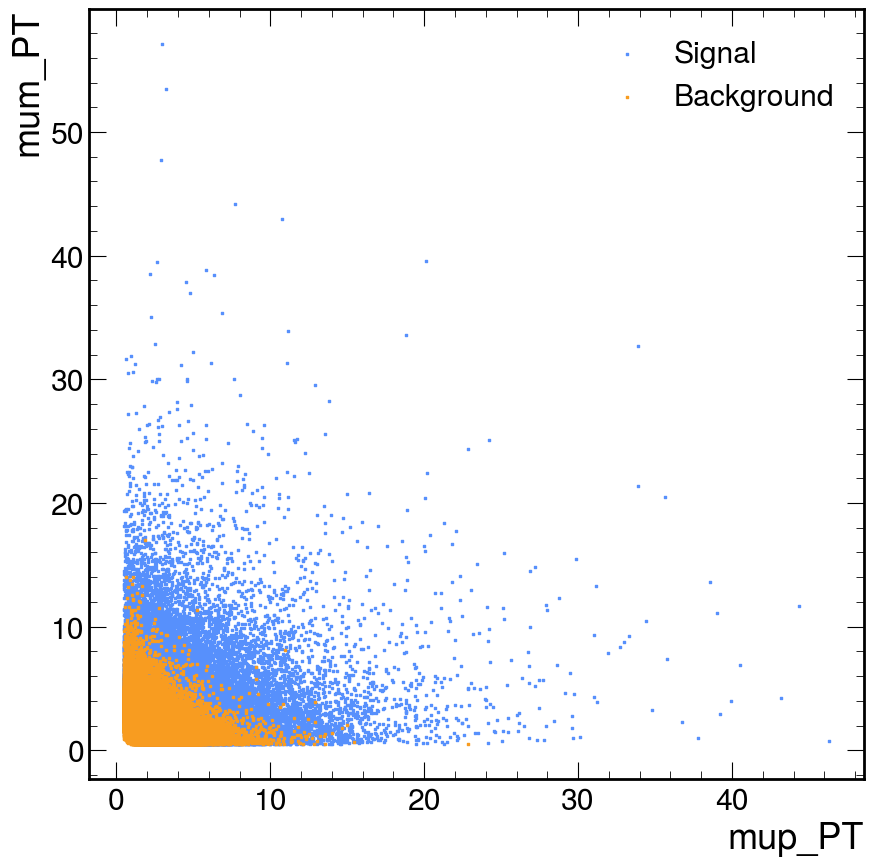

In [5]:
plt.scatter(mc_df['mup_PT'], mc_df['mum_PT'], s=1, marker=',', label='Signal')
plt.scatter(bkg_df['mup_PT'], bkg_df['mum_PT'], s=1, marker=',', label='Background')
plt.xlabel('mup_PT')
plt.ylabel('mum_PT')
plt.legend()

In [6]:
training_columns = [
    'Jpsi_PT',
    'mup_PT', 'mup_eta', 'mup_ProbNNmu',
    'mum_PT', 'mum_eta', 'mum_ProbNNmu',
]
# Store training_columns
%store training_columns

Stored 'training_columns' (list)


In [7]:
# We then define the classifier we want to use
# bdt = GradientBoostingClassifier()  # we could also use this one
bdt = XGBClassifier(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better

In [8]:
bkg_df = bkg_df.copy()
bkg_df['catagory'] = 0  # Use 0 for background
mc_df['catagory'] = 1  # Use 1 for signal

In [9]:
# Now merge the data together
training_data = pd.concat([bkg_df, mc_df], copy=True, ignore_index=True)
# Store training_data for later
%store training_data

Stored 'training_data' (DataFrame)


In [10]:
# We can now fit the BDT
bdt.fit(training_data[training_columns], training_data['catagory'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
bdt.predict_proba(data_df[training_columns].head())

array([[0.0951997 , 0.9048003 ],
       [0.22529536, 0.77470464],
       [0.63189864, 0.3681014 ],
       [0.6602049 , 0.33979508],
       [0.36177772, 0.6382223 ]], dtype=float32)

In [12]:
# We can now use slicing to select column 1 in the array from for all rows
probabilities = bdt.predict_proba(data_df[training_columns])[:,1]
probabilities

array([0.9048003 , 0.77470464, 0.3681014 , ..., 0.367871  , 0.22820437,
       0.29143938], dtype=float32)

In [13]:
mc_df['BDT'] = bdt.predict_proba(mc_df[training_columns])[:,1]
bkg_df['BDT'] = bdt.predict_proba(bkg_df[training_columns])[:,1]
data_df['BDT'] = bdt.predict_proba(data_df[training_columns])[:,1]
training_data['BDT'] = bdt.predict_proba(training_data[training_columns])[:,1]

In [14]:
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT'] = bdt.predict_proba(df[training_columns])[:,1]

In [15]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)

    mplhep.histplot((hsig, bins), label='MC Signal', )
    mplhep.histplot(hbkg, bins=bins, label='Data Bkg')
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')


def plot_mass(df, **kwargs):
    h, bins = np.histogram(df['Jpsi_M'], bins=100, range=[2.75, 3.5])
    mplhep.histplot(h, bins, yerr=True, **kwargs)  # feel free to adjust
    # You can also use LaTeX in the axis label
    plt.xlabel('$J/\\psi$ mass [GeV]')
    plt.xlim(bins[0], bins[-1])

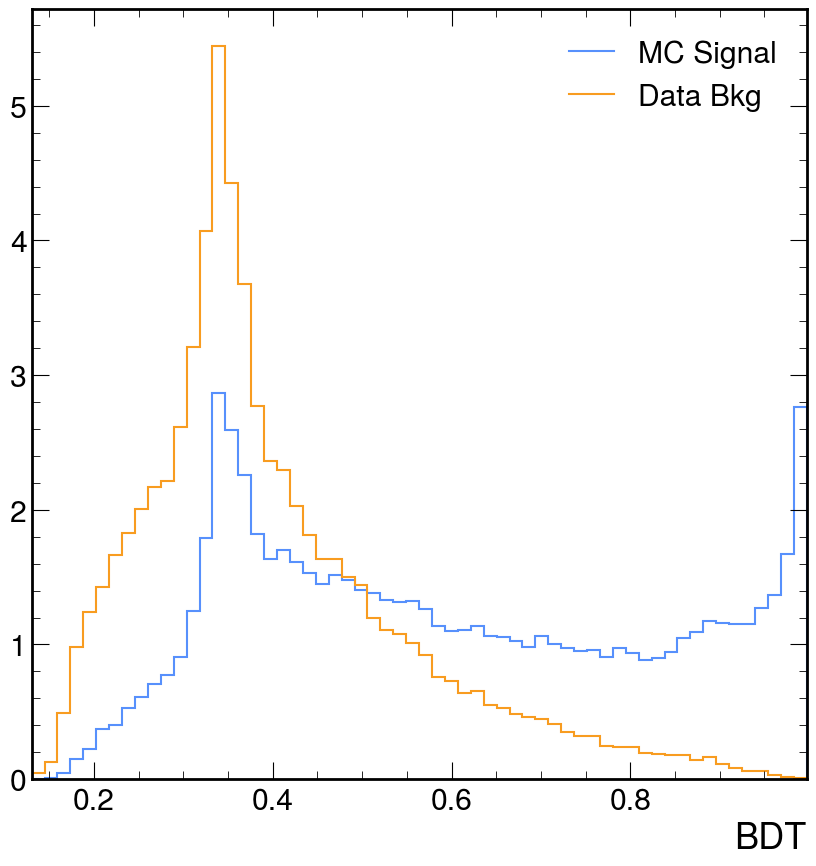

In [16]:
plot_comparision('BDT', mc_df, bkg_df)

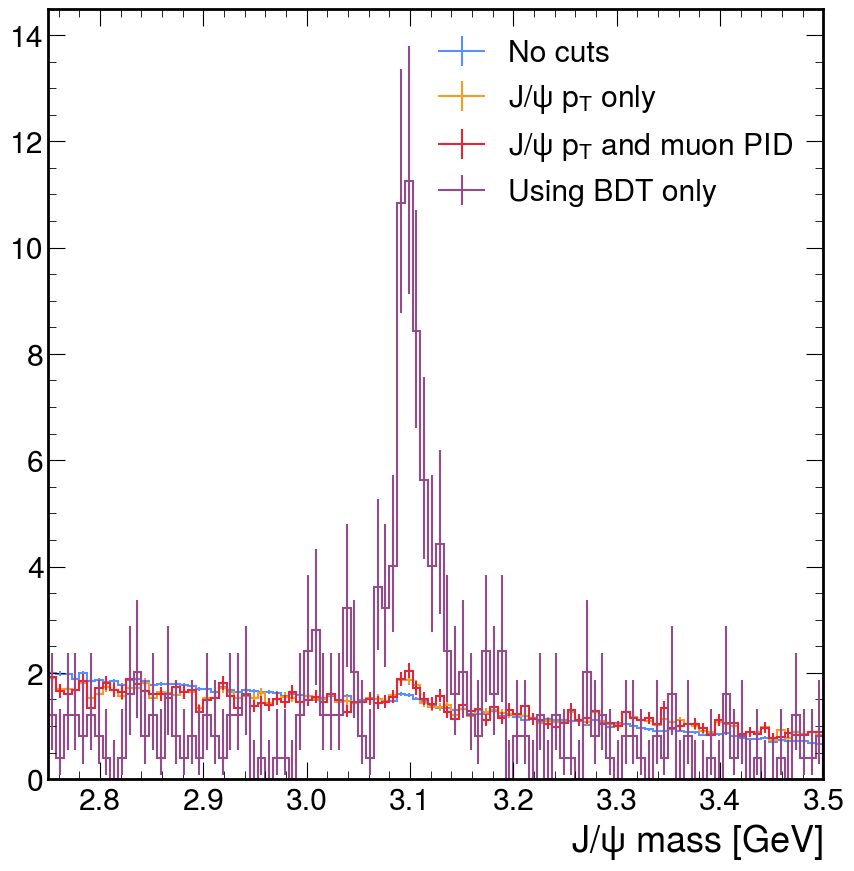

In [17]:
plot_mass(data_df, label='No cuts', density=1)

data_with_cuts_df = data_df.query('Jpsi_PT > 4')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ only', density=1)

data_with_cuts_df = data_df.query('(Jpsi_PT > 4) & ((mum_ProbNNmu > 0.9) & (mup_ProbNNmu > 0.9))')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ and muon PID', density=1)

data_with_cuts_df = data_df.query('BDT > 0.95')
plot_mass(data_with_cuts_df, label='Using BDT only', density=1)

plt.legend(loc='best')

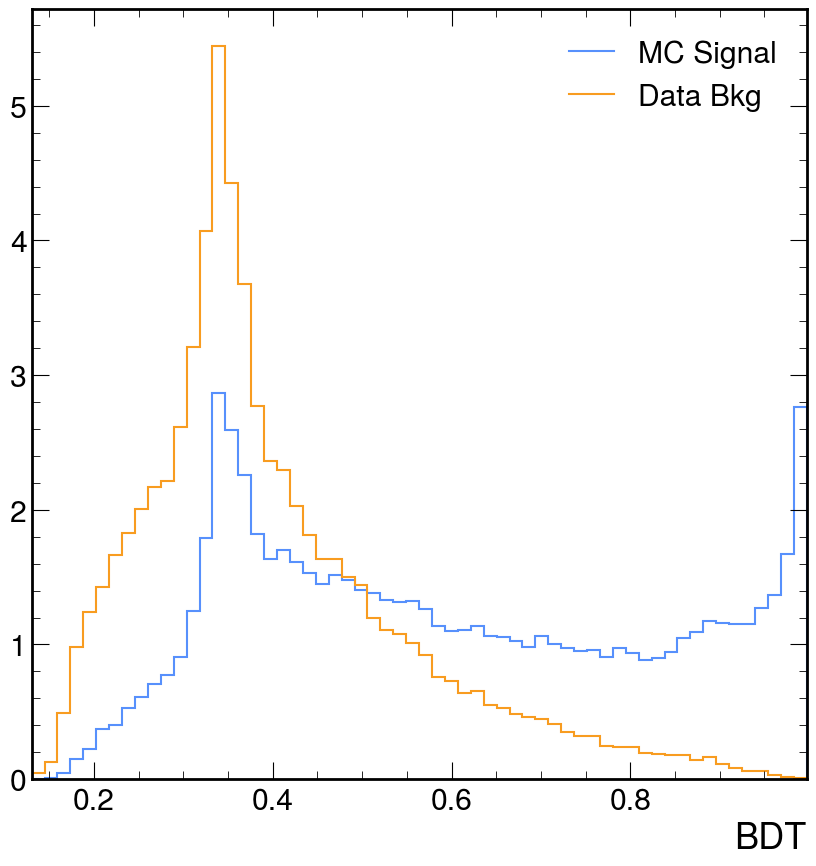

In [19]:
plot_comparision('BDT', mc_df, bkg_df)

In [20]:
y_score = bdt.predict_proba(training_data[training_columns])[:,1]
fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

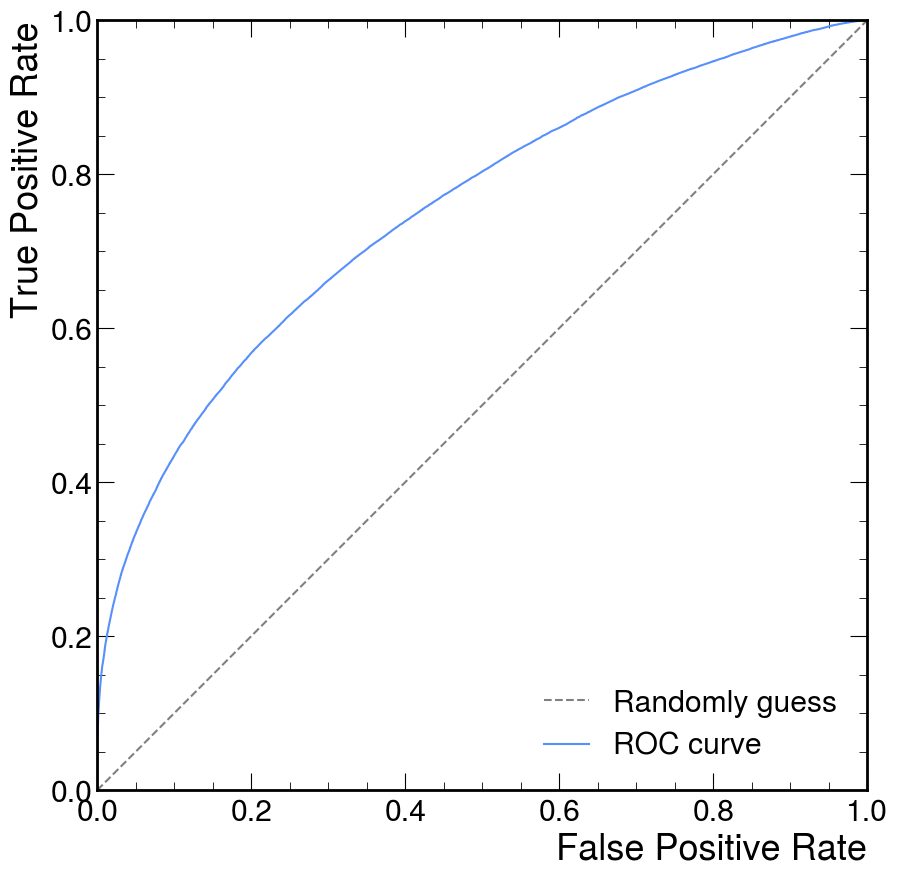

In [21]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Randomly guess')
plt.plot(fpr, tpr, label=f'ROC curve')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

In [22]:
area = auc(fpr, tpr)

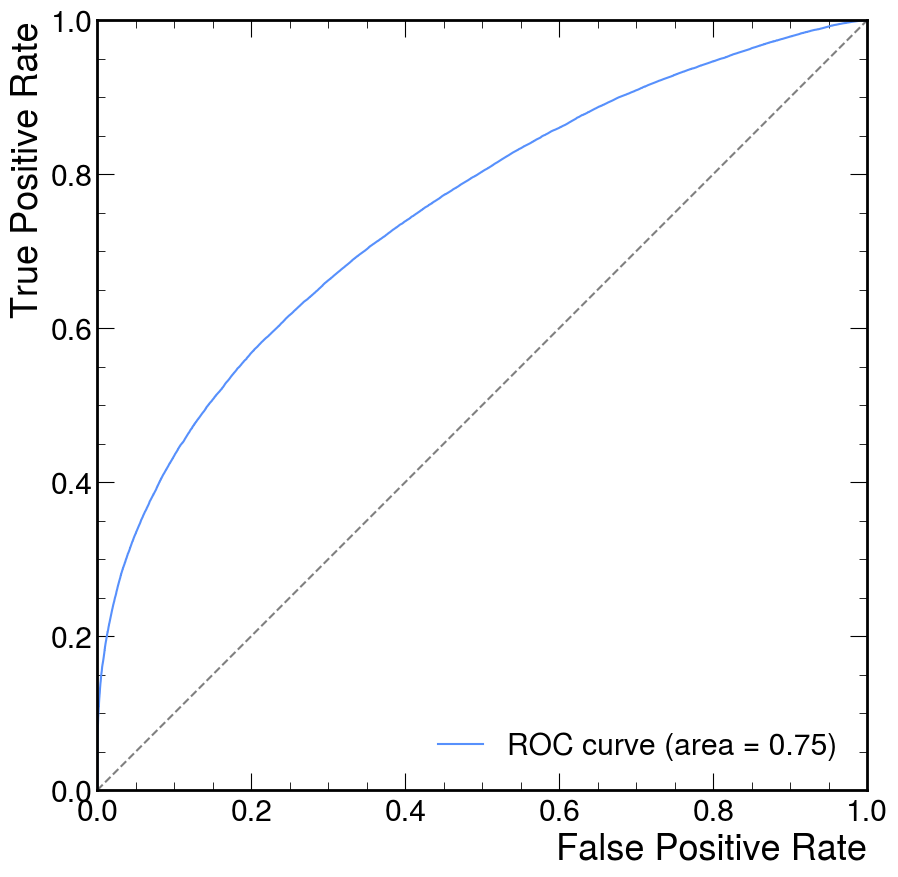

In [23]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

In [24]:
n_sig = 1200
n_bkg = 23000

In [25]:
S = n_sig*tpr
B = n_bkg*fpr
metric = S/np.sqrt(S+B)

/var/folders/kw/0czmm3990g5fnnpcxpc0ff_40000gn/T/ipykernel_76414/4020814425.py:3: RuntimeWarning: invalid value encountered in divide
  metric = S/np.sqrt(S+B)


(0.0, 1.0)

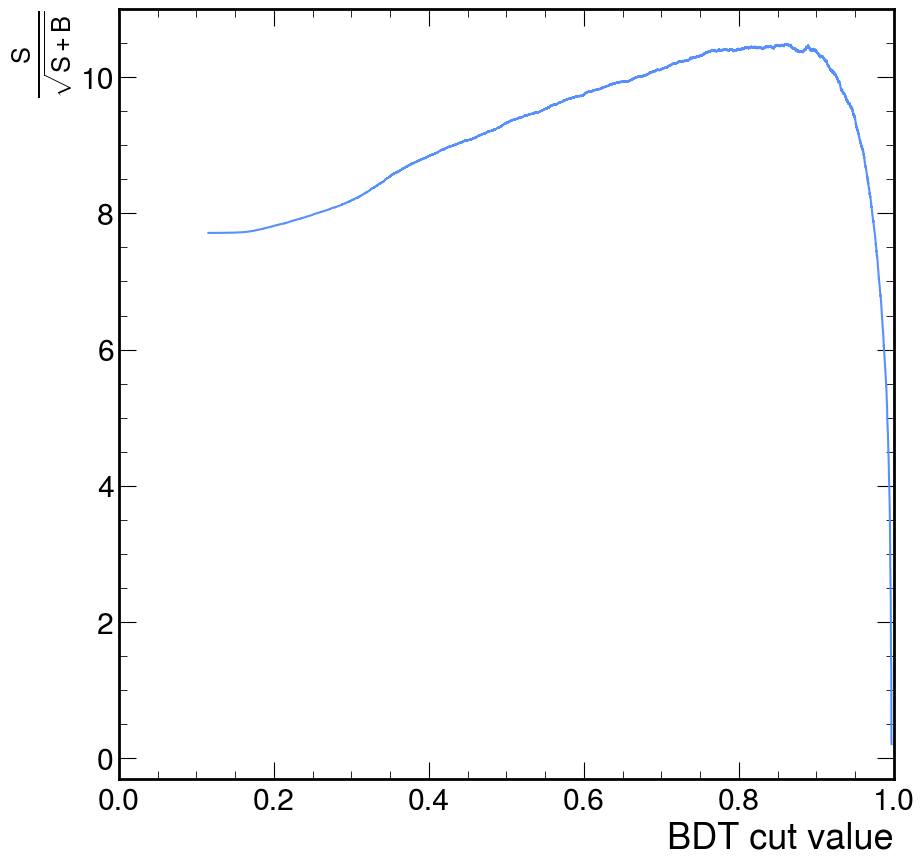

In [26]:
plt.plot(thresholds, metric)
plt.xlabel('BDT cut value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlim(0, 1.0)

In [27]:
optimal_index = np.argmax(metric)
optimal_metric = metric[optimal_index]
optimal_cut = thresholds[optimal_index]
print(f'The optimal cut value is {optimal_cut:.2f} with and S/sqrt(S+B) of {optimal_metric:.2f}')

The optimal cut value is inf with and S/sqrt(S+B) of nan


/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:273: RuntimeWarning: divide by zero encountered in scalar divide
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:245: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:246: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale


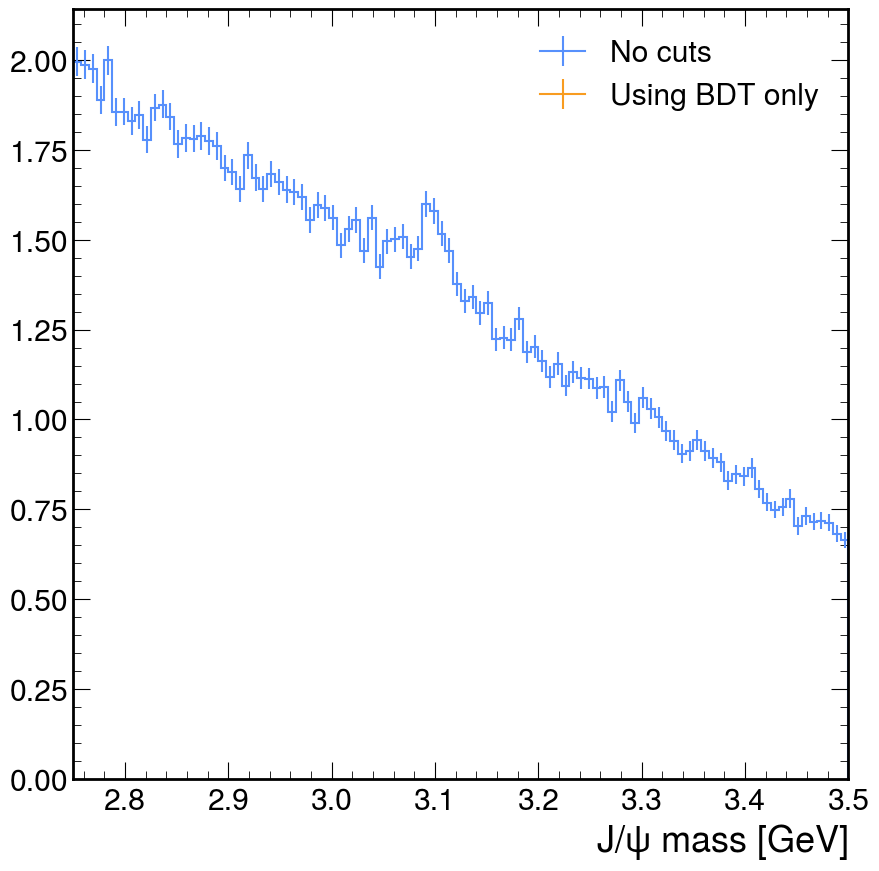

In [28]:
plot_mass(data_df, label='No cuts', density=1)

data_with_cuts_df = data_df.query(f'BDT > {optimal_cut}')
plot_mass(data_with_cuts_df, label='Using BDT only', density=1)

plt.legend(loc='best')

/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


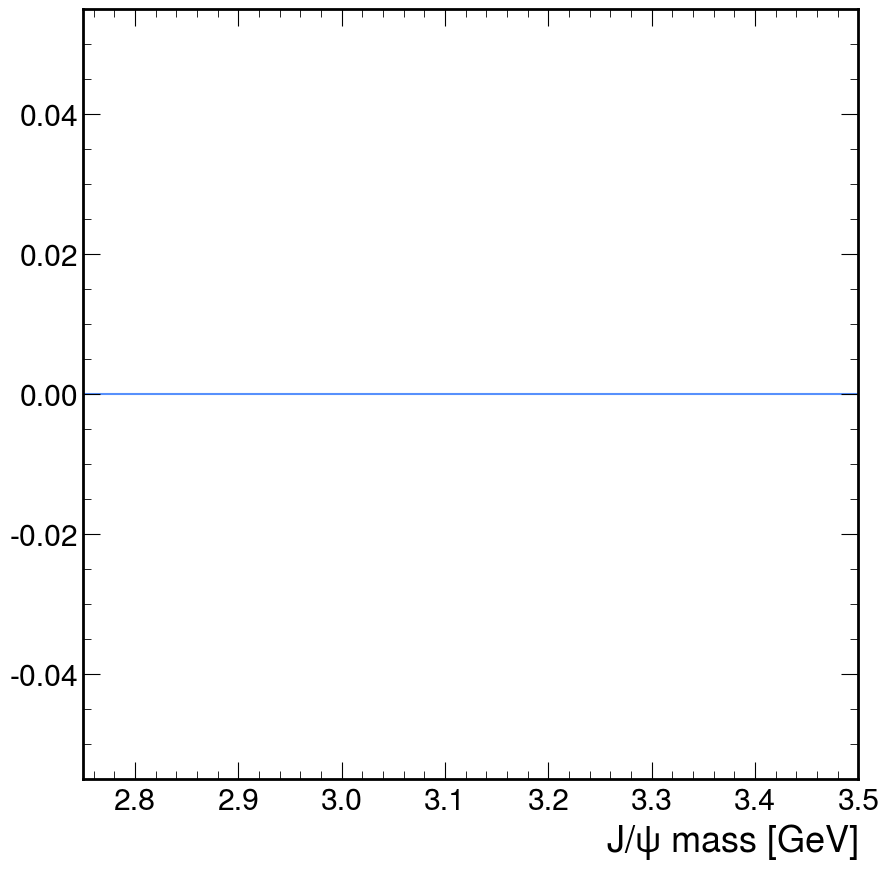

In [29]:
plot_mass(data_with_cuts_df, label='Using BDT only')

In [30]:
def plot_roc(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

In [31]:
def plot_significance(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

    n_sig = 1200
    n_bkg = 23000
    S = n_sig*tpr
    B = n_bkg*fpr
    metric = S/np.sqrt(S+B)

    plt.plot(thresholds, metric, label=label)
    plt.xlabel('BDT cut value')
    plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
    plt.xlim(0, 1.0)

    optimal_cut = thresholds[np.argmax(metric)]
    plt.axvline(optimal_cut, color='black', linestyle='--')

Data succesfully loaded


/var/folders/kw/0czmm3990g5fnnpcxpc0ff_40000gn/T/ipykernel_76414/4278176416.py:9: RuntimeWarning: invalid value encountered in divide
  metric = S/np.sqrt(S+B)


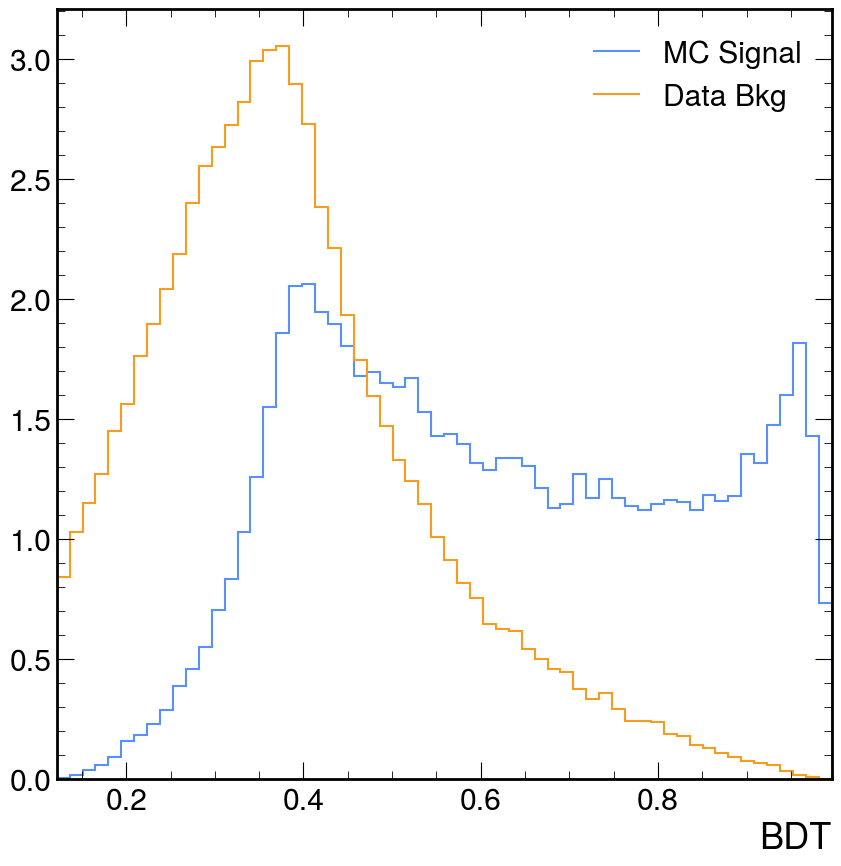

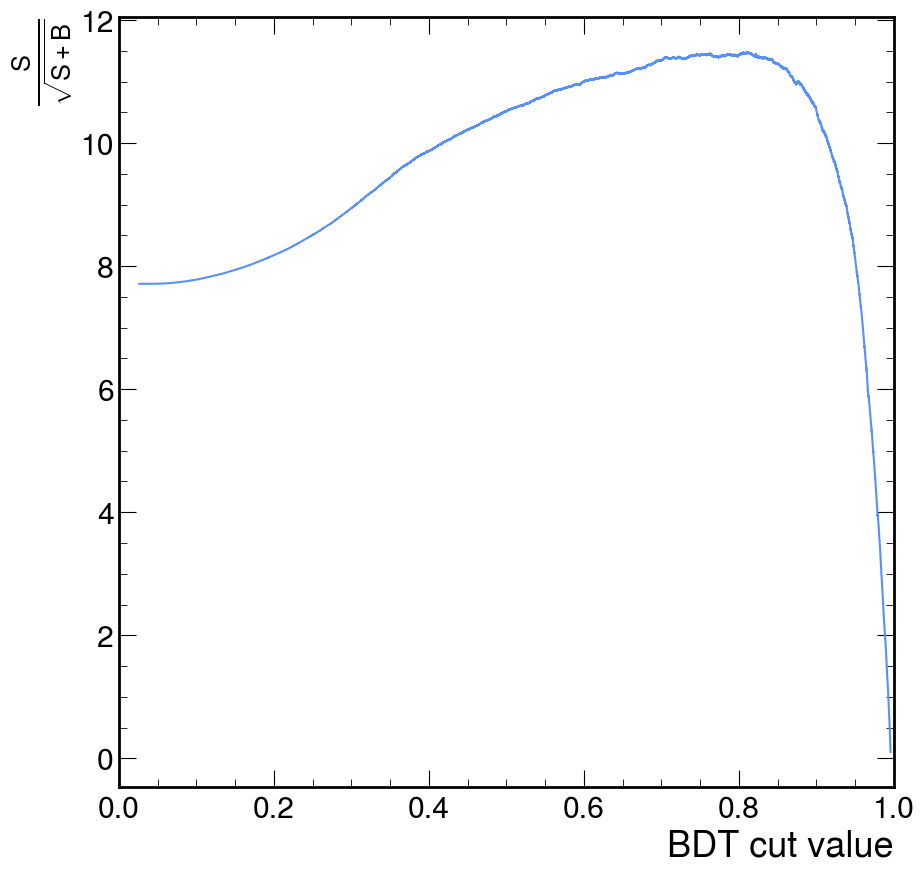

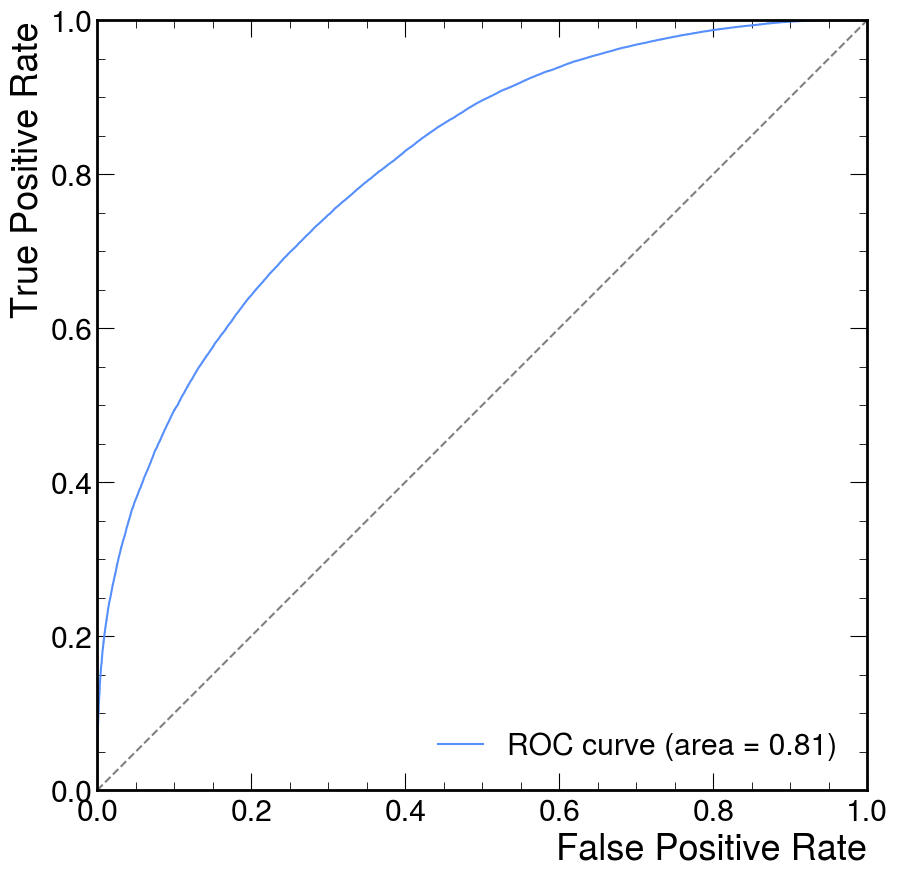

In [32]:
with uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/real_data.root') as datafile:
    data_df = datafile['DecayTree'].arrays(library='pd')
with uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/simulated_data.root') as mcfile:
    mc_df = mcfile['DecayTree'].arrays(library='pd')

print("Data succesfully loaded")
bkg_df = data_df.query('~(3.0 < Jpsi_M < 3.2)').copy()

for df in [mc_df, data_df, bkg_df]:
    df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
    df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
    df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)

training_columns = [
    'Jpsi_PT',
    'mup_PT', 'mup_eta', 'mup_ProbNNmu', 'mup_IP',
    'mum_PT', 'mum_eta', 'mum_ProbNNmu', 'mum_IP',
]

bkg_df['catagory'] = 0  # Use 0 for background
mc_df['catagory'] = 1  # Use 1 for signal
training_data = pd.concat([bkg_df, mc_df], copy=True, ignore_index=True)

bdt = GradientBoostingClassifier()
bdt.fit(training_data[training_columns], training_data['catagory'])

mc_df['BDT'] = bdt.predict_proba(mc_df[training_columns])[:,1]
bkg_df['BDT'] = bdt.predict_proba(bkg_df[training_columns])[:,1]
data_df['BDT'] = bdt.predict_proba(data_df[training_columns])[:,1]
training_data['BDT'] = bdt.predict_proba(training_data[training_columns])[:,1]

plt.figure()
plot_comparision('BDT', mc_df, bkg_df)

plt.figure()
plot_significance(bdt, training_data, training_columns)

plt.figure()
plot_roc(bdt, training_data, training_columns)

In [33]:
%store bkg_df
%store mc_df
%store data_df

Stored 'bkg_df' (DataFrame)
Stored 'mc_df' (DataFrame)
Stored 'data_df' (DataFrame)
